<a href="https://colab.research.google.com/github/kridtapon/AroonFrama-Fusion/blob/main/AroonFrama_Fusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Function to calculate the Fractal Adaptive Moving Average (FRAMA)
def calculate_frama(df, period=15):
    """
    Calculate Fractal Adaptive Moving Average (FRAMA).
    """
    hl = df['High'] - df['Low']
    hl_rolling = hl.rolling(window=period).sum()

    s = (df['Close'] - df['Close'].shift(period)).abs().rolling(window=period).sum()
    frama = df['Close'].ewm(span=period).mean() + (hl_rolling / s)

    return frama

# Function to calculate Aroon Indicator
def calculate_aroon(df, period=14):
    """
    Calculate Aroon Indicator (Aroon Up and Aroon Down).
    """
    aroon_up = ((df['Close'].rolling(window=period).apply(lambda x: np.argmax(x) + 1) / period) * 100)
    aroon_down = ((df['Close'].rolling(window=period).apply(lambda x: np.argmin(x) + 1) / period) * 100)

    return aroon_up, aroon_down

# Define the stock symbol and time period
symbol = 'META'  # SPY is the symbol for the S&P 500 ETF
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Calculate Fractal Adaptive Moving Average (FRAMA)
df['FRAMA'] = calculate_frama(df, period=15)

# Calculate Aroon Indicator (Aroon Up and Aroon Down)
df['Aroon_Up'], df['Aroon_Down'] = calculate_aroon(df, period=14)

# Define Entry and Exit signals based on FRAMA and Aroon Indicator
df['Entry'] = (df['FRAMA'] > df['FRAMA'].shift(1)) & (df['Aroon_Up'] > df['Aroon_Down'])
df['Exit'] = (df['FRAMA'] < df['FRAMA'].shift(1)) & (df['Aroon_Down'] > df['Aroon_Up'])

# Filter data for the test period (2020-2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'sharpe_ratio' requires frequency to be set
  warnings.warn(warning_message)
/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'calmar_ratio' requires frequency to be set
  warnings.warn(warning_message)
/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'omega_ratio' requires frequency to be set
  warnings.warn(warning_message)
/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'sortino_ratio' requires frequency to be set
  warnings.warn(warning_message)


Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           115703.730063
Total Return [%]                         15.70373
Benchmark Return [%]                   180.172876
Max Gross Exposure [%]                      100.0
Total Fees Paid                       7197.544032
Max Drawdown [%]                        67.520207
Max Drawdown Duration                      1148.0
Total Trades                                   40
Total Closed Trades                            40
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                 30.0
Best Trade [%]                          40.381999
Worst Trade [%]                        -14.137964
Avg Winning Trade [%]                   15.142006
Avg Losing Trade [%]                     -5.00703


[*********************100%***********************]  1 of 1 completed


Best Parameters: FRAMA Period: 20, Aroon Period: 8, Shift: 8
Best Performance: 2.9574748000806648


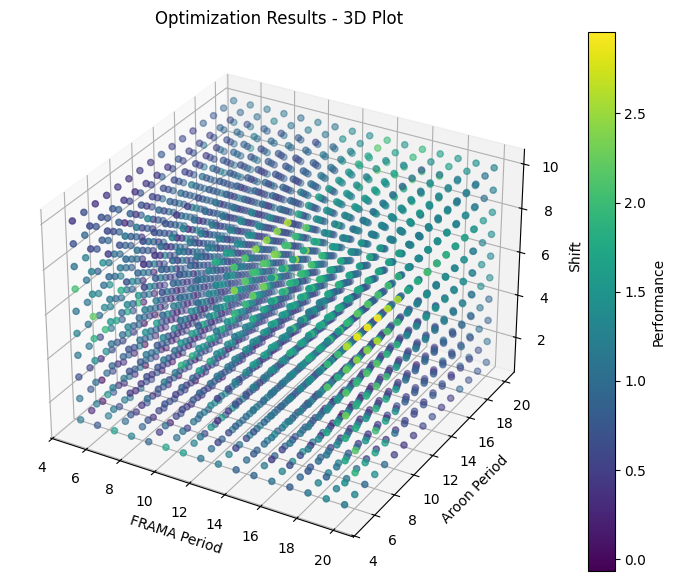

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           395747.480008
Total Return [%]                        295.74748
Benchmark Return [%]                   250.750183
Max Gross Exposure [%]                      100.0
Total Fees Paid                       9419.201614
Max Drawdown [%]                        35.343138
Max Drawdown Duration                       630.0
Total Trades                                   23
Total Closed Trades                            23
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            60.869565
Best Trade [%]                          36.014008
Worst Trade [%]                        -10.170454
Avg Winning Trade [%]                   14.431299
Avg Losing Trade [%]                     -4.83289


In [6]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to calculate the Fractal Adaptive Moving Average (FRAMA)
def calculate_frama(df, period=15):
    hl = df['High'] - df['Low']
    hl_rolling = hl.rolling(window=period).sum()
    s = (df['Close'] - df['Close'].shift(period)).abs().rolling(window=period).sum()
    frama = df['Close'].ewm(span=period).mean() + (hl_rolling / s)
    return frama

# Function to calculate Aroon Indicator
def calculate_aroon(df, period=14):
    aroon_up = ((df['Close'].rolling(window=period).apply(lambda x: np.argmax(x) + 1) / period) * 100)
    aroon_down = ((df['Close'].rolling(window=period).apply(lambda x: np.argmin(x) + 1) / period) * 100)
    return aroon_up, aroon_down

# Define stock symbol and period
symbol = 'HWM'
start_date = '2020-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

def optimize_parameters(df, frama_range, aroon_range, shift_range):
    best_params = None
    best_performance = -np.inf
    results = []

    for frama_period, aroon_period, shift_val in itertools.product(frama_range, aroon_range, shift_range):
        df['FRAMA'] = calculate_frama(df, period=frama_period)
        df['Aroon_Up'], df['Aroon_Down'] = calculate_aroon(df, period=aroon_period)
        df['Entry'] = (df['FRAMA'] > df['FRAMA'].shift(shift_val)) & (df['Aroon_Up'] > df['Aroon_Down'])
        df['Exit'] = (df['FRAMA'] < df['FRAMA'].shift(shift_val)) & (df['Aroon_Down'] > df['Aroon_Up'])

        portfolio = vbt.Portfolio.from_signals(
            close=df['Close'], entries=df['Entry'], exits=df['Exit'], init_cash=100_000, fees=0.001
        )
        performance = portfolio.total_return()
        results.append((frama_period, aroon_period, shift_val, performance))

        if performance > best_performance:
            best_performance = performance
            best_params = (frama_period, aroon_period, shift_val)

    return best_params, best_performance, results

# Define parameter ranges
frama_range = range(5, 21)  # Test periods 5 to 20
aroon_range = range(5, 21)  # Test periods 5 to 20
shift_range = range(1, 11)  # Test shift values from 1 to 10

best_params, best_performance, results = optimize_parameters(df, frama_range, aroon_range, shift_range)
print(f'Best Parameters: FRAMA Period: {best_params[0]}, Aroon Period: {best_params[1]}, Shift: {best_params[2]}')
print(f'Best Performance: {best_performance}')

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['FRAMA Period', 'Aroon Period', 'Shift', 'Performance'])

# Plot 3D visualization
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(results_df['FRAMA Period'], results_df['Aroon Period'], results_df['Shift'], c=results_df['Performance'], cmap='viridis', marker='o')
ax.set_xlabel('FRAMA Period')
ax.set_ylabel('Aroon Period')
ax.set_zlabel('Shift')
ax.set_title('Optimization Results - 3D Plot')
fig.colorbar(sc, label='Performance')
plt.show()

# Backtest with the best parameters
df['FRAMA'] = calculate_frama(df, period=best_params[0])
df['Aroon_Up'], df['Aroon_Down'] = calculate_aroon(df, period=best_params[1])
df['Entry'] = (df['FRAMA'] > df['FRAMA'].shift(best_params[2])) & (df['Aroon_Up'] > df['Aroon_Down'])
df['Exit'] = (df['FRAMA'] < df['FRAMA'].shift(best_params[2])) & (df['Aroon_Down'] > df['Aroon_Up'])

portfolio = vbt.Portfolio.from_signals(
    close=df['Close'], entries=df['Entry'], exits=df['Exit'], init_cash=100_000, fees=0.001
)
print(portfolio.stats())
portfolio.plot().show()